In [1]:
import numpy as np
from forban.bandits import NormalBandit
from forban.sequentialg import SequentiAlg
from forban.utils import Experiment, randamax, klGaussian, plot_bandit

In [2]:
class Constant(SequentiAlg):
    def __init__(self, bandit, name="Constant", params={'init': 1, 'choice': 0 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.choice = params['choice']
        self.name = f"{self.name} (arm {self.choice})"
        assert self.choice < bandit.nbr_arms, f"'choice' ({self.choice}) should be one of\
the arms indices (<{bandit.nbr_arms})"
    
    def compute_indices(self):
        self.indices[self.choice] = 0
        
        
class Etc(SequentiAlg):
    def __init__(self, bandit, name="ETC", params={'init': 0, 'exploration': 200 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.exploration = params['exploration']
        
    def compute_indices(self):
        if self.time <= self.exploration:
            # probably faster computation is possible
            self.indices = np.random.rand(self.bandit.nbr_arms)
        else:
            self.indices = self.means
            
    def choose_an_arm(self):
        return randamax(self.indices)

    
class IMED(SequentiAlg):
    def __init__(self, bandit, name="IMED", params={'init': -np.inf, 'kl':klGaussian}):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.kl = params['kl']
    
    def compute_indices(self):
        max_mean = np.max(self.means)
        if self.all_selected:
            self.indices = self.nbr_pulls*self.kl(self.means, max_mean) + np.log(self.nbr_pulls)
        else:
            for arm in np.where(self.nbr_pulls != 0)[0]:
                self.indices[arm] = self.nbr_pulls[arm]*self.kl(self.means[arm], max_mean) \
                + np.log(self.nbr_pulls[arm])

In [3]:
means = [0.2, 0.5, 0., 0.3]
bandit = NormalBandit(means)
seqalg1 = Constant(bandit)
seqalg2 = SequentiAlg(bandit, name="Random")
seqalg3 = Constant(bandit, params = {'init': 1, 'choice': 3})
seqalg4 = Etc(bandit)
seqalg5 = IMED(bandit)

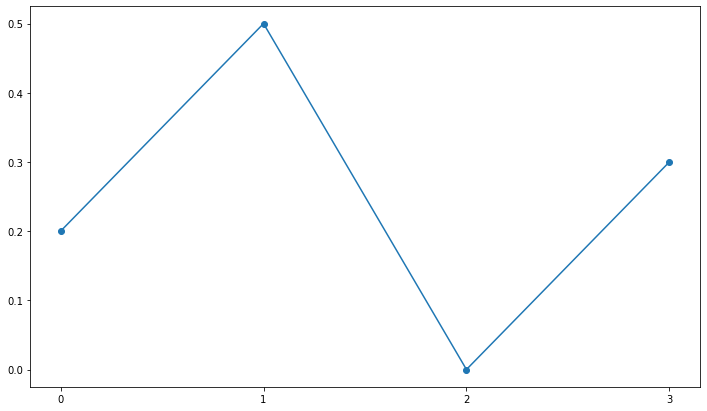

In [4]:
plot_bandit(bandit)

In [5]:
experiment = Experiment([seqalg1, seqalg2, seqalg3, seqalg4, seqalg5], bandit,
                        statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                        complexity=True)

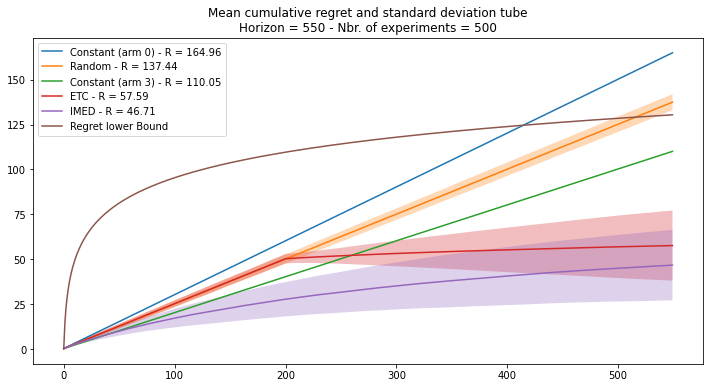

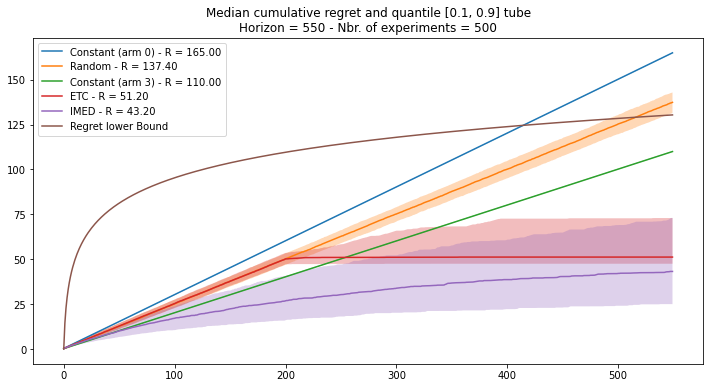

In [6]:
experiment.run(500, 550)
experiment.plot()